In [1]:
! pip install pysindy

In [2]:
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
np.math = math

In [45]:
###############################################################################
# 0. UPLOAD & EXTRACT DATA FROM ZIP FILE (if needed)
###############################################################################
# Uncomment the following lines to upload a zip file.
#from google.colab import files
#import zipfile, io
#
#uploaded = files.upload()
#
#for filename in uploaded.keys():
#    if filename.endswith('.zip'):
#        print("Extracting from", filename)
#        with zipfile.ZipFile(io.BytesIO(uploaded[filename]), 'r') as z:
#            z.extractall()
#        print("Extracted files:", z.namelist())

###############################################################################
# 1. LOAD DATA FROM CSV
###############################################################################
import pandas as pd
# Adjust this path according to your extracted folder structure in Colab:
csv_path = "prod_export_20250412_1744430420/PROCESSED/data_ncov2019.csv"
df = pd.read_csv(csv_path)
print("DataFrame shape:", df.shape)
print(df.head())

DataFrame shape: (9615934, 19)
  EVENT_NAME              SOURCE    DATE_LOW   DATE_HIGH DATE_REPORT  \
0  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
1  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
2  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
3  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
4  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   

       DATE_TYPE SPATIAL_RESOLUTION AL0_CODE AL0_NAME AL1_CODE AL1_NAME  \
0  Symptom onset                AL0       CN    China      NaN      NaN   
1  Symptom onset                AL0       CN    China      NaN      NaN   
2  Symptom onset                AL0       CN    China      NaN      NaN   
3  Symptom onset                AL0       CN    China      NaN      NaN   
4  Symptom onset                AL0       CN    China      NaN      NaN   

  AL2_NAME AL3_NAME LOCALITY_NAME LOCATION_TYPE CONFIRM_STATUS OUTCOME  \
0      NaN 

In [53]:
###############################################################################
# 2. PREPROCESS DATA: EXTRACT DAILY TIME SERIES FOR A CHOSEN COUNTRY
###############################################################################
# We assume the DataFrame contains the following columns:
# 'AL0_NAME', 'OUTCOME', 'CUMULATIVE_FLAG', 'DATE_REPORT', and 'VALUE'
country = 'France'

# Create masks for cumulative cases and deaths
mask_cases  = (df['AL0_NAME'] == country) & (df['OUTCOME'] == 'CASE') & (df['CUMULATIVE_FLAG'])
mask_deaths = (df['AL0_NAME'] == country) & (df['OUTCOME'] == 'DEATH') & (df['CUMULATIVE_FLAG'])

def make_daily_series(subdf):
    """Aggregate duplicate dates (using mean), then resample to daily frequency and interpolate."""
    tmp = subdf.copy()
    tmp['DATE'] = pd.to_datetime(tmp['DATE_REPORT'])
    tmp = tmp.set_index('DATE').sort_index()
    ser = tmp['VALUE'].groupby(level=0).mean()  # Aggregate duplicates
    ser = ser.asfreq('D').interpolate()         # Ensure a complete daily series
    return ser

# Build cumulative series for confirmed cases (C) and deaths (D)
C = make_daily_series(df[mask_cases])
D = make_daily_series(df[mask_deaths]).reindex(C.index).interpolate()
D = D.fillna(0)  # Assume 0 deaths if missing

###############################################################################
# 3. CONSTRUCT S, I, R TIME SERIES
###############################################################################
# Define:
#   - S(t) = Population - C(t)
#   - I(t) = 14-day rolling window of new cases (proxy for active cases)
#   - R(t) = C(t) - I(t) - D(t)
pop_N = 65_500_000  # Example: Population of France
new_cases = C.diff().fillna(0)
I_series = new_cases.rolling(window=14, min_periods=1).sum()
S_series = pop_N - C
R_series = C - I_series - D

# Align lengths and drop any residual NaNs
min_len = min(len(S_series), len(I_series), len(R_series))
S_series, I_series, R_series = S_series.iloc[:min_len], I_series.iloc[:min_len], R_series.iloc[:min_len]

# Combine into a DataFrame with a DateTime index
data = pd.concat({'S': S_series, 'I': I_series, 'R': R_series}, axis=1).dropna()
print("Processed data (first 5 rows):")
print(data.head())

###############################################################################
# 4. PREPARE DATA MATRIX FOR SINDY
###############################################################################
# Convert the DataFrame to a NumPy array of type float64.
X = data.to_numpy(dtype=np.float64)   # Shape should be (T, 3); e.g., (1795, 3)
print("X shape:", X.shape)

Processed data (first 5 rows):
                      S     I    R
DATE                              
2020-01-31  65499997.00  0.00  3.0
2020-02-01  65499996.75  0.25  3.0
2020-02-02  65499996.50  0.50  3.0
2020-02-03  65499996.25  0.75  3.0
2020-02-04  65499996.00  1.00  3.0
X shape: (1795, 3)



=== Discovered ODEs ===
(S)' = -9934638.295 1 + 0.152 S + 0.097 I + 0.152 R
(I)' = -16029.861 1
(R)' = 14596122.089 1 + -0.223 S + -0.170 I + -0.224 R


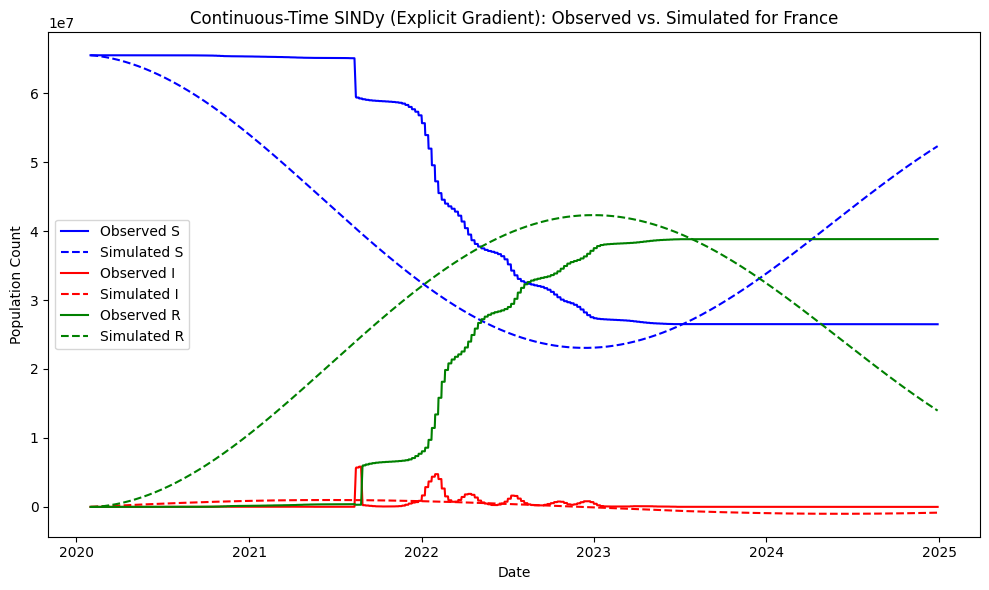

In [72]:
###############################################################################
# 5. MANUALLY COMPUTE DERIVATIVES & FIT SINDY
###############################################################################
import numpy as np
import pysindy as ps

# Compute derivatives for S, I, R using np.gradient
dt = 1.0  # Daily data, so dt=1 day
S_dot = np.gradient(data['S'].values, dt)
I_dot = np.gradient(data['I'].values, dt)
R_dot = np.gradient(data['R'].values, dt)

# Stack derivatives into a matrix X_dot (shape [T, 3])
X_dot = np.column_stack((S_dot, I_dot, R_dot))

# Use Polynomial features (degree 2) for the SIR model
feature_library = ps.PolynomialLibrary(degree=2, include_bias=True)

# Initialize SINDy model (no differentiation_method needed since we provide X_dot)
model = ps.SINDy(
    feature_library=feature_library,
    optimizer=ps.STLSQ(threshold=0.0001),  # Adjust threshold as needed
    feature_names=['S', 'I', 'R']
)

# Fit the model using the original data X and precomputed derivatives X_dot
model.fit(data[['S', 'I', 'R']].values, t=dt, x_dot=X_dot)

# Display discovered equations
print("\n=== Discovered ODEs ===")
model.print()

import matplotlib.pyplot as plt
T = X.shape[0]
t_sim = np.linspace(0, (T-1)*dt, T)
X_sim = model.simulate(X[0], t_sim)

plt.figure(figsize=(10,6))
plt.plot(data.index, X[:,0], 'b', label='Observed S')
plt.plot(data.index, X_sim[:,0], 'b--', label='Simulated S')
plt.plot(data.index, X[:,1], 'r', label='Observed I')
plt.plot(data.index, X_sim[:,1], 'r--', label='Simulated I')
plt.plot(data.index, X[:,2], 'g', label='Observed R')
plt.plot(data.index, X_sim[:,2], 'g--', label='Simulated R')
plt.xlabel("Date")
plt.ylabel("Population Count")
plt.title(f"Continuous-Time SINDy (Explicit Gradient): Observed vs. Simulated for {country}")
plt.legend()
plt.tight_layout()
plt.show()

Library size: 20 terms

=== Sparse ODEs  (window 2021-06-15→2021-10-15,  α=2e-06) ===
          ds/dt        di/dt        dr/dt
     1:   2.592e-03  -6.683e-03   4.143e-03
     i:  -4.814e-04  -3.458e-03   3.934e-03
    ss:  -2.542e-03   4.095e-03  -1.601e-03
   sss:  -7.639e-04   3.380e-03  -2.633e-03
   ssi:  -4.788e-02   1.859e-02   2.846e-02


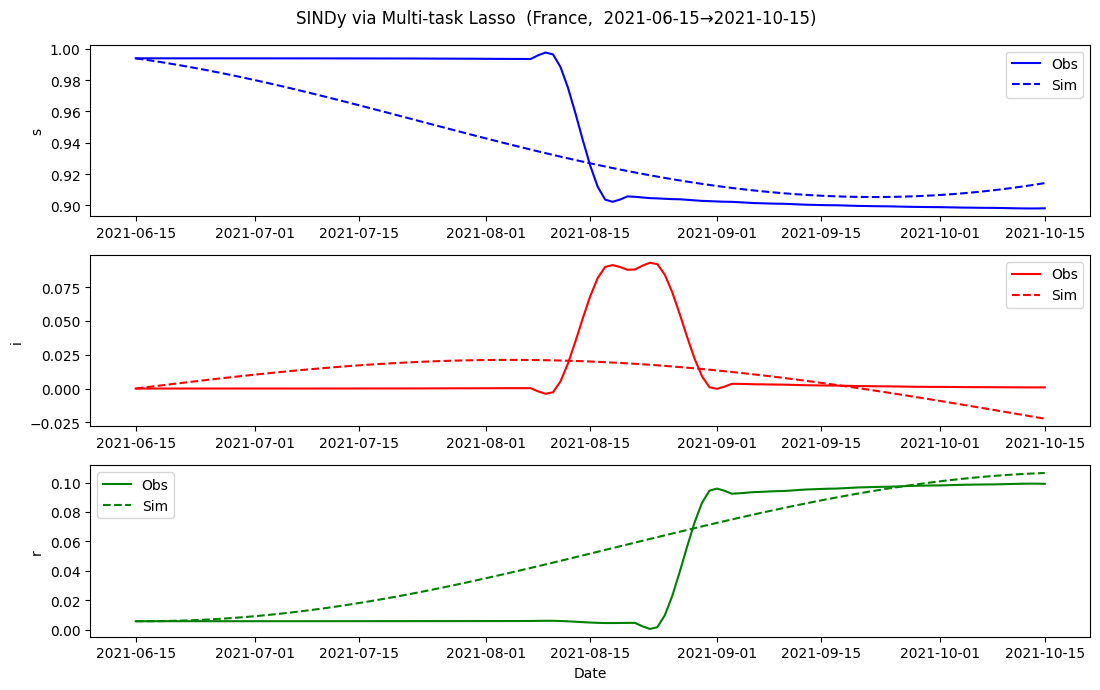

In [100]:
###############################################################################
# 0. USER SETTINGS  ── adjust only these five lines
###############################################################################
country      = 'France'
start_date   = '2021-06-15'     #  ←  narrower window
end_date     = '2021-10-15'
pop_N        = 65_500_000
alpha_lasso  = 2e-6             #  sparsity knob (try 1e‑6 … 1e‑4)

###############################################################################
# 1. LOAD DAILY C(t) & D(t), BUILD S,I,R
###############################################################################
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.linear_model import MultiTaskLasso
from itertools import combinations_with_replacement
from scipy.integrate import solve_ivp

csv = "prod_export_20250412_1744430420/PROCESSED/data_ncov2019.csv"
df  = pd.read_csv(csv)

def daily(mask):
    tmp = df.loc[mask, ['DATE_REPORT','VALUE']].copy()
    tmp['DATE'] = pd.to_datetime(tmp.DATE_REPORT)
    return (tmp.set_index('DATE')
              .VALUE.groupby(level=0).mean()
              .asfreq('D').interpolate())

mC = (df.AL0_NAME==country)&(df.OUTCOME=='CASE') &(df.CUMULATIVE_FLAG)
mD = (df.AL0_NAME==country)&(df.OUTCOME=='DEATH')&(df.CUMULATIVE_FLAG)
C  = daily(mC);  D = daily(mD).reindex(C.index).interpolate().fillna(0)

C, D = C.loc[start_date:end_date], D.loc[start_date:end_date]
new  = C.diff().fillna(0)
I    = new.rolling(14,1).sum()
S    = pop_N - C
R    = C - I - D
data = pd.concat({'S':S,'I':I,'R':R}, axis=1).dropna()

###############################################################################
# 2. FRACTIONS & SMOOTHED DERIVATIVES
###############################################################################
s, i, r = (data / pop_N).values.T
s_s = savgol_filter(s, 11, 3)
i_s = savgol_filter(i, 11, 3)
r_s = savgol_filter(r, 11, 3)
ds, di, dr = np.gradient(s_s), np.gradient(i_s), np.gradient(r_s)

###############################################################################
# 3. BUILD AN EXPANDED FEATURE LIBRARY
#    1, linear, pairwise products, quadratics, cubics
###############################################################################
def build_library(s, i, r, degree=3):
    col_names = ['1']
    X_cols    = [np.ones_like(s)]
    # linear terms
    for name, vec in zip(['s','i','r'], [s,i,r]):
        col_names.append(name); X_cols.append(vec)
    # polynomial interaction terms up to chosen degree
    base = [s, i, r]; base_names = ['s','i','r']
    for d in range(2, degree+1):
        for idx in combinations_with_replacement(range(3), d):
            vec = np.prod([base[j] for j in idx], axis=0)
            name = ''.join(base_names[j] for j in idx)
            col_names.append(name); X_cols.append(vec)
    return np.column_stack(X_cols), col_names

X, feat_names = build_library(s_s, i_s, r_s, degree=3)
Y            = np.column_stack([ds, di, dr])

print("Library size:", len(feat_names), "terms")

###############################################################################
# 4. MULTI‑TASK LASSO FIT
###############################################################################
lasso = MultiTaskLasso(alpha=alpha_lasso, fit_intercept=False, max_iter=1_000_000)
lasso.fit(X, Y)
B = lasso.coef_.T   # shape (features, 3)

###############################################################################
# 5. PRINT SPARSE EQUATIONS
###############################################################################
print(f"\n=== Sparse ODEs  (window {start_date}→{end_date},  α={alpha_lasso}) ===")
print("          ds/dt        di/dt        dr/dt")
for n,row in zip(feat_names, B):
    if np.any(np.abs(row) > 1e-6):
        print(f"{n:>6}: {row[0]:>11.3e} {row[1]:>11.3e} {row[2]:>11.3e}")

###############################################################################
# 6. SIMULATE THE IDENTIFIED MODEL
###############################################################################
def rhs(t, y):
    vals = np.array([1, *y])                 # start with 1, s, i, r
    # build higher‑order monomials on the fly
    extra = []
    for d in range(2,4):
        for idx in combinations_with_replacement(range(3), d):
            extra.append(np.prod([y[j] for j in idx]))
    Xrow = np.concatenate([vals, extra])
    return B.T @ Xrow

t_eval = np.arange(len(s_s))
sol = solve_ivp(rhs, (0, len(s_s)-1), [s_s[0], i_s[0], r_s[0]],
                t_eval=t_eval, rtol=1e-9, atol=1e-9)

###############################################################################
# 7. PLOT OBSERVED vs SIMULATED (fractions)
###############################################################################
plt.figure(figsize=(11,7))
labs, cols = ['s','i','r'], ['b','r','g']
for k,series in enumerate([s_s, i_s, r_s]):
    plt.subplot(3,1,k+1)
    plt.plot(data.index, series, cols[k],  label='Obs')
    plt.plot(data.index, sol.y[k], cols[k]+'--', label='Sim')
    plt.ylabel(labs[k]); plt.legend()
plt.xlabel("Date")
plt.suptitle(f"SINDy via Multi‑task Lasso  ({country},  {start_date}→{end_date})")
plt.tight_layout(); plt.show()


Library size: 20 terms

=== Sparse ODEs  (window 2021-06-15→2021-10-15,  α=1e-10) ===
          ds/dt        di/dt        dr/dt
     1:  -7.694e-05  -1.375e-04   2.129e-04
     i:  -5.856e-02   3.936e-04   5.805e-02
     r:   2.572e-03  -6.159e-03   3.531e-03
    ss:   2.200e-05   1.071e-04  -1.281e-04
   sss:   3.156e-05   8.862e-05  -1.192e-04


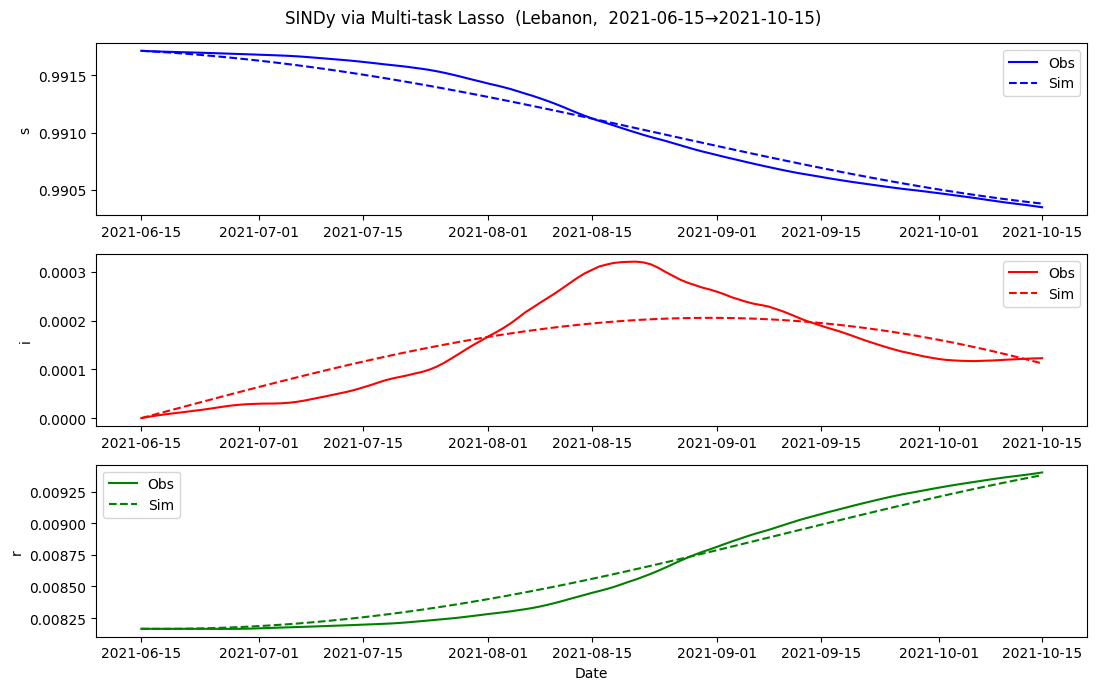

In [103]:
###############################################################################
# 0. USER SETTINGS  ── adjust only these five lines
###############################################################################
country      = 'Lebanon'
start_date   = '2021-01-15'     #  ←  narrower window
end_date     = '2021-12-15'
pop_N        = 65_500_000
alpha_lasso  = 0.0000000001          #  sparsity knob (try 1e‑6 … 1e‑4)

###############################################################################
# 1. LOAD DAILY C(t) & D(t), BUILD S,I,R
###############################################################################
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.linear_model import MultiTaskLasso
from itertools import combinations_with_replacement
from scipy.integrate import solve_ivp

csv = "prod_export_20250412_1744430420/PROCESSED/data_ncov2019.csv"
# df  = pd.read_csv(csv)

def daily(mask):
    tmp = df.loc[mask, ['DATE_REPORT','VALUE']].copy()
    tmp['DATE'] = pd.to_datetime(tmp.DATE_REPORT)
    return (tmp.set_index('DATE')
              .VALUE.groupby(level=0).mean()
              .asfreq('D').interpolate())

mC = (df.AL0_NAME==country)&(df.OUTCOME=='CASE') &(df.CUMULATIVE_FLAG)
mD = (df.AL0_NAME==country)&(df.OUTCOME=='DEATH')&(df.CUMULATIVE_FLAG)
C  = daily(mC);  D = daily(mD).reindex(C.index).interpolate().fillna(0)

C, D = C.loc[start_date:end_date], D.loc[start_date:end_date]
new  = C.diff().fillna(0)
I    = new.rolling(14,1).sum()
S    = pop_N - C
R    = C - I - D
data = pd.concat({'S':S,'I':I,'R':R}, axis=1).dropna()

###############################################################################
# 2. FRACTIONS & SMOOTHED DERIVATIVES
###############################################################################
s, i, r = (data / pop_N).values.T
s_s = savgol_filter(s, 11, 3)
i_s = savgol_filter(i, 11, 3)
r_s = savgol_filter(r, 11, 3)
ds, di, dr = np.gradient(s_s), np.gradient(i_s), np.gradient(r_s)

###############################################################################
# 3. BUILD AN EXPANDED FEATURE LIBRARY
#    1, linear, pairwise products, quadratics, cubics
###############################################################################
def build_library(s, i, r, degree=3):
    col_names = ['1']
    X_cols    = [np.ones_like(s)]
    # linear terms
    for name, vec in zip(['s','i','r'], [s,i,r]):
        col_names.append(name); X_cols.append(vec)
    # polynomial interaction terms up to chosen degree
    base = [s, i, r]; base_names = ['s','i','r']
    for d in range(2, degree+1):
        for idx in combinations_with_replacement(range(3), d):
            vec = np.prod([base[j] for j in idx], axis=0)
            name = ''.join(base_names[j] for j in idx)
            col_names.append(name); X_cols.append(vec)
    return np.column_stack(X_cols), col_names

X, feat_names = build_library(s_s, i_s, r_s, degree=3)
Y            = np.column_stack([ds, di, dr])

print("Library size:", len(feat_names), "terms")

###############################################################################
# 4. MULTI‑TASK LASSO FIT
###############################################################################
lasso = MultiTaskLasso(alpha=alpha_lasso, fit_intercept=False, max_iter=1_000_000)
lasso.fit(X, Y)
B = lasso.coef_.T   # shape (features, 3)

###############################################################################
# 5. PRINT SPARSE EQUATIONS
###############################################################################
print(f"\n=== Sparse ODEs  (window {start_date}→{end_date},  α={alpha_lasso}) ===")
print("          ds/dt        di/dt        dr/dt")
for n,row in zip(feat_names, B):
    if np.any(np.abs(row) > 1e-6):
        print(f"{n:>6}: {row[0]:>11.3e} {row[1]:>11.3e} {row[2]:>11.3e}")

###############################################################################
# 6. SIMULATE THE IDENTIFIED MODEL
###############################################################################
def rhs(t, y):
    vals = np.array([1, *y])                 # start with 1, s, i, r
    # build higher‑order monomials on the fly
    extra = []
    for d in range(2,4):
        for idx in combinations_with_replacement(range(3), d):
            extra.append(np.prod([y[j] for j in idx]))
    Xrow = np.concatenate([vals, extra])
    return B.T @ Xrow

t_eval = np.arange(len(s_s))
sol = solve_ivp(rhs, (0, len(s_s)-1), [s_s[0], i_s[0], r_s[0]],
                t_eval=t_eval, rtol=1e-9, atol=1e-9)

###############################################################################
# 7. PLOT OBSERVED vs SIMULATED (fractions)
###############################################################################
plt.figure(figsize=(11,7))
labs, cols = ['s','i','r'], ['b','r','g']
for k,series in enumerate([s_s, i_s, r_s]):
    plt.subplot(3,1,k+1)
    plt.plot(data.index, series, cols[k],  label='Obs')
    plt.plot(data.index, sol.y[k], cols[k]+'--', label='Sim')
    plt.ylabel(labs[k]); plt.legend()
plt.xlabel("Date")
plt.suptitle(f"SINDy via Multi‑task Lasso  ({country},  {start_date}→{end_date})")
plt.tight_layout(); plt.show()



Library size: 15
=== Sparse SIDR model  α=1e-09 ===
            ds/dt        di/dt        dd/dt        dr/dt
     1:  -5.654e-04   1.235e-04   5.962e-06   4.359e-04
     r:  -5.307e-03   6.071e-03  -3.378e-06  -7.605e-04
    ss:  -6.391e-04   1.656e-03   6.470e-06  -1.023e-03
    si:   1.932e-02  -9.712e-02   7.857e-04   7.701e-02
    sr:   3.035e-02  -4.495e-02  -2.249e-04   1.482e-02
    ir:  -8.715e-01   8.072e-01   1.666e-04   6.416e-02
    rr:  -1.140e-01   2.059e-01   8.746e-04  -9.278e-02


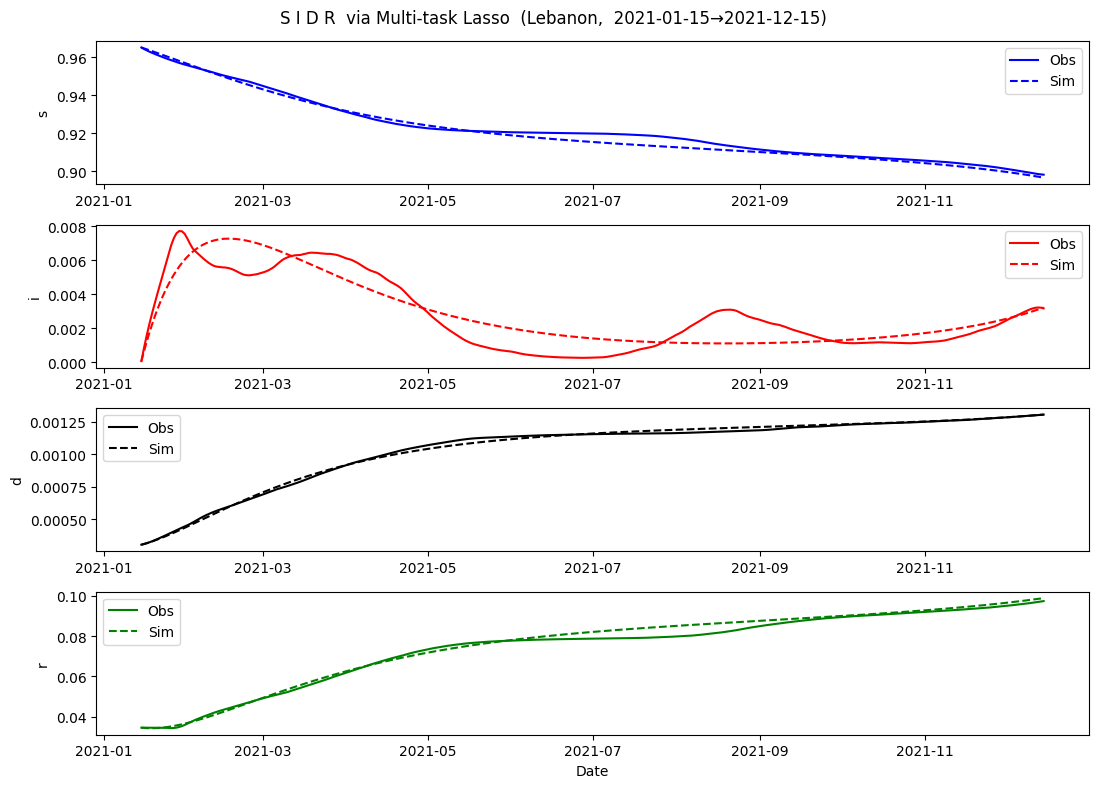

In [107]:
###############################################################################
# 0. USER SETTINGS
###############################################################################
country     = 'Lebanon'
start_date  = '2021-01-15'
end_date    = '2021-12-15'
pop_N       = 6_800_000          # Lebanon pop
alpha       = 1e-9               # Lasso sparsity
degree      = 2                  # polynomial library order
smooth_win  = 11                 # Savitzky window (odd)
smooth_poly = 3

###############################################################################
# 1. LOAD DAILY C,D AND BUILD S,I,D,R
###############################################################################
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.linear_model import MultiTaskLasso
from itertools import combinations_with_replacement
from scipy.integrate import solve_ivp

# df = pd.read_csv("prod_export_20250412_1744430420/PROCESSED/data_ncov2019.csv")

def daily(mask):
    sub = df.loc[mask, ['DATE_REPORT','VALUE']].copy()
    sub['DATE'] = pd.to_datetime(sub.DATE_REPORT)
    return (sub.set_index('DATE')
              .VALUE.groupby(level=0).mean()
              .asfreq('D').interpolate())

mC = (df.AL0_NAME==country)&(df.OUTCOME=='CASE') &(df.CUMULATIVE_FLAG)
mD = (df.AL0_NAME==country)&(df.OUTCOME=='DEATH')&(df.CUMULATIVE_FLAG)
C  = daily(mC);  D = daily(mD).reindex(C.index).interpolate().fillna(0)

C, D = C.loc[start_date:end_date], D.loc[start_date:end_date]
new   = C.diff().fillna(0)
I     = new.rolling(14,1).sum()
S     = pop_N - C
R     = C - I - D
data  = pd.concat({'S':S,'I':I,'D':D,'R':R}, axis=1).dropna()

###############################################################################
# 2. FRACTIONS + SMOOTHED DERIVATIVES
###############################################################################
fractions   = (data / pop_N).values       # columns: s,i,d,r
f_s         = savgol_filter(fractions, smooth_win, smooth_poly, axis=0)
dfdt        = np.gradient(f_s, axis=0)    # numerical derivative
s,i,d,r     = f_s.T
ds,di,dd,dr = dfdt.T

###############################################################################
# 3. BUILD POLYNOMIAL LIBRARY up to chosen degree
###############################################################################
names  = ['s','i','d','r']
base   = [s,i,d,r]
Xcols, fnames = [np.ones_like(s)], ['1']
for deg in range(1, degree+1):
    for idx in combinations_with_replacement(range(4), deg):
        Xcols.append(np.prod([base[j] for j in idx], axis=0))
        fnames.append(''.join(names[j] for j in idx))
X = np.column_stack(Xcols)
Y = np.column_stack([ds, di, dd, dr])

###############################################################################
# 4. MULTI‑TASK LASSO
###############################################################################
lasso = MultiTaskLasso(alpha=alpha, fit_intercept=False, max_iter=1_000_000)
lasso.fit(X, Y)
B = lasso.coef_.T          # (features, 4)

print("\nLibrary size:", len(fnames))
print(f"=== Sparse SIDR model  α={alpha} ===")
print("            ds/dt        di/dt        dd/dt        dr/dt")
for n,row in zip(fnames, B):
    if np.any(np.abs(row) > 1e-7):
        print(f"{n:>6}: {row[0]:>11.3e} {row[1]:>11.3e} {row[2]:>11.3e} {row[3]:>11.3e}")

###############################################################################
# 5. SIMULATE (stop if solver fails)
###############################################################################
def rhs(t, y):
    vec = [1, *y]  # constant + linear
    for deg in range(2, degree+1):
        for idx in combinations_with_replacement(range(4), deg):
            vec.append(np.prod([y[j] for j in idx]))
    return B.T @ np.array(vec)

t_eval = np.arange(len(s))
sol    = solve_ivp(rhs, (0, len(s)-1), f_s[0], t_eval=t_eval,
                   rtol=1e-9, atol=1e-9, max_step=1.0)

###############################################################################
# 6. PLOT (truncate to solver length if it stopped early)
###############################################################################
obs_index = data.index[:len(sol.t)]
plt.figure(figsize=(11,8))
labs, cols = ['s','i','d','r'], ['b','r','k','g']
for k in range(4):
    plt.subplot(4,1,k+1)
    plt.plot(obs_index, f_s[:len(sol.t),k], cols[k], label='Obs')
    plt.plot(obs_index, sol.y[k], cols[k]+'--', label='Sim')
    plt.ylabel(labs[k]); plt.legend()
plt.xlabel("Date")
plt.suptitle(f"S I D R  via Multi‑task Lasso  ({country},  {start_date}→{end_date})")
plt.tight_layout(); plt.show()



=== SINDy SIDR model (degree 2, threshold = 1e-09 ) ===
(s)' = -214.856 1 + 429.940 s + 273.337 i + -1391.544 d + 473.411 r + -215.087 s^2 + -273.616 s i + 1392.227 s d + -473.585 s r + -53.855 i^2 + 909.207 i d + -308.398 i r + -5208.365 d^2 + 1515.387 d r + -259.993 r^2
(i)' = 959.593 1 + -1918.873 s + -1796.403 i + 6838.687 d + -2163.819 r + 959.282 s^2 + 1796.361 s i + -6837.942 s d + 2163.430 s r + 819.891 i^2 + -6444.159 i d + 2031.503 i r + 27690.943 d^2 + -7570.155 d r + 1211.402 r^2
(d)' = 8.690 1 + -17.360 s + -18.932 i + 65.121 d + -20.138 r + 8.670 s^2 + 18.914 s i + -65.062 s d + 20.117 s r + 10.180 i^2 + -69.785 i d + 21.758 i r + 273.509 d^2 + -73.542 d r + 11.529 r^2
(r)' = -753.427 1 + 1506.293 s + 1541.998 i + -5512.264 d + 1710.546 r + -752.865 s^2 + -1541.660 s i + 5510.777 s d + -1709.962 s r + -776.217 i^2 + 5604.737 i d + -1744.862 i r + -22756.087 d^2 + 6128.309 d r + -962.939 r^2


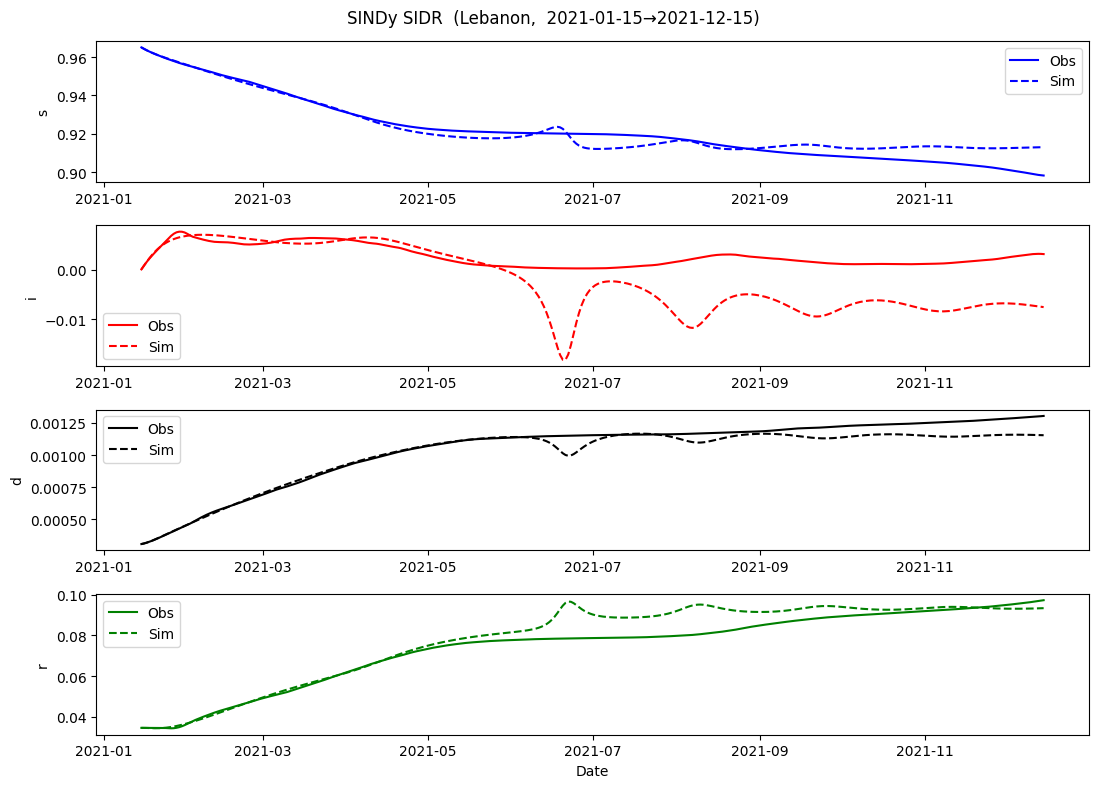

In [108]:
###############################################################################
# 3.  BUILD PY‑SINDy LIBRARY (degree‑2 polynomials) & FIT
###############################################################################
import pysindy as ps

dt = 1.0                                    # daily spacing
library = ps.PolynomialLibrary(degree=degree, include_bias=True)

# ---  give PySINDy the smoothed data and *explicit* derivatives -------------
model = ps.SINDy(feature_library = library,
                 optimizer       = ps.STLSQ(threshold=alpha),   # alpha≈Lasso
                 feature_names   = ['s','i','d','r'],
                 discrete_time   = False)

model.fit(f_s, t=dt, x_dot=dfdt)
print("\n=== SINDy SIDR model (degree 2, threshold =", alpha, ") ===")
model.print()

###############################################################################
# 4.  SIMULATE WITH model.simulate()  ----------------------------------------
###############################################################################
t_sim = np.arange(len(s)) * dt
X_sim = model.simulate(f_s[0], t_sim)        # shape (T, 4)

###############################################################################
# 5.  PLOT
###############################################################################
obs_index = data.index                       # same length as t_sim
plt.figure(figsize=(11,8))
labs, cols = ['s','i','d','r'], ['b','r','k','g']
for k in range(4):
    plt.subplot(4,1,k+1)
    plt.plot(obs_index, f_s[:,k], cols[k],      label='Obs')
    plt.plot(obs_index, X_sim[:,k], cols[k]+'--', label='Sim')
    plt.ylabel(labs[k]); plt.legend()
plt.xlabel("Date")
plt.suptitle(f"SINDy SIDR  ({country},  {start_date}→{end_date})")
plt.tight_layout(); plt.show()


Symbolic Regression

In [109]:
!pip install pysr --quiet
import pysr
from pysr import pysr, best

# example: fit di/dt  --------------------------------------------------------
X_pysr = f_s[:, :4]                 # columns s,i,d,r
y_pysr = di                         # target derivative

model_i = pysr(
    X_pysr,
    y_pysr,
    niterations       = 1000,
    binary_operators  = ["+", "-", "*"],
    unary_operators   = [],        # add "sin", "exp", ... if desired
    variable_names    = ["s","i","d","r"],
    loss              = "loss(x, y) = (x - y)^2",
    populations       = 10,
    progress          = False,
)
print("\nBest expression for di/dt:")
# print(best(model_i))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 3.9 MB/s eta 0:00:00
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Using Julia 1.10.9 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="SymbolicRegression", uuid="8254be44-1295-4e6a-a16d-46603ac705cb"), Pkg.PackageSpec(name="Serialization", uuid="9e88b42a-f829-5b0c-bbe9-9e923198166b"), Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d")])
           j

/usr/local/lib/python3.11/dist-packages/pysr/deprecated.py:30: FutureWarning: Calling `pysr` is deprecated. Please use `model = PySRRegressor(**params); model.fit(X, y)` going forward.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:1027: FutureWarning: `variable_names` is a data-dependent parameter and should be passed when fit is called. Ignoring parameter; please pass `variable_names` during the call to fit instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
Compiling Julia backend...
INFO:pysr.sr:Compiling Julia backend...
[ Info: Started!


Streaming output truncated to the last 5000 lines.
                                      * (x₀ * (x₂ + -0.0011913))
19          7.111e-09  1.916e-02  y = (((x₂ * -652.94) + 0.98524) * (x₂ + -0.001179)) * ((((...
                                      x₂ * -20.803) - x₁) + 0.018188) * -107.44)
21          7.100e-09  7.480e-04  y = ((x₂ + -0.001186) * (((x₂ * -20.803) + (0.018225 - x₁)...
                                      ) * -107.21)) * (((x₂ * x₀) * -652.94) + x₀)
23          6.811e-09  2.079e-02  y = (((x₂ * -20.803) - x₁) + 0.018325) * ((((x₂ * ((x₁ + x...
                                      ₁) * -59959)) + x₀) * -92.824) * (x₂ + -0.0012))
25          6.807e-09  2.534e-04  y = (((x₂ * -20.803) - x₁) + 0.018325) * (((((x₂ * (x₁ + x...
                                      ₁)) * -59959) + (x₁ + x₀)) * -92.824) * (x₂ + -0.0012))
27          6.798e-09  6.499e-04  y = ((((((x₂ + x₂) * (1.6278 - (x₁ * -653.96))) * -91.685)...
                                       + 1.139) * -91.685) 

[ Info: Final population:
[ Info: Results saved to:



Best expression for di/dt:


NotImplementedError: `best` has been deprecated. Please use the `PySRRegressor` interface. After fitting, you can return `.sympy()` to get the sympy representation of the best equation.

  - outputs/20250412_180327_ActzLh/hall_of_fame.csv


In [111]:
for name, eq in zip(['s','i','d','r'], model.equations()):
    print(f"\\frac{{d{name}}}{{dt}} = {eq} \\\\")


\frac{ds}{dt} = -214.856 1 + 429.940 s + 273.337 i + -1391.544 d + 473.411 r + -215.087 s^2 + -273.616 s i + 1392.227 s d + -473.585 s r + -53.855 i^2 + 909.207 i d + -308.398 i r + -5208.365 d^2 + 1515.387 d r + -259.993 r^2 \\
\frac{di}{dt} = 959.593 1 + -1918.873 s + -1796.403 i + 6838.687 d + -2163.819 r + 959.282 s^2 + 1796.361 s i + -6837.942 s d + 2163.430 s r + 819.891 i^2 + -6444.159 i d + 2031.503 i r + 27690.943 d^2 + -7570.155 d r + 1211.402 r^2 \\
\frac{dd}{dt} = 8.690 1 + -17.360 s + -18.932 i + 65.121 d + -20.138 r + 8.670 s^2 + 18.914 s i + -65.062 s d + 20.117 s r + 10.180 i^2 + -69.785 i d + 21.758 i r + 273.509 d^2 + -73.542 d r + 11.529 r^2 \\
\frac{dr}{dt} = -753.427 1 + 1506.293 s + 1541.998 i + -5512.264 d + 1710.546 r + -752.865 s^2 + -1541.660 s i + 5510.777 s d + -1709.962 s r + -776.217 i^2 + 5604.737 i d + -1744.862 i r + -22756.087 d^2 + 6128.309 d r + -962.939 r^2 \\
